In [1]:
import sys
sys.path.append('.')

import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import sklearn
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import FunctionTransformer as FT

from lib.Extractor import FeatureExtractor
from lib.Models import FullyConnectedNetworkRegressor
from lib.Datasets import TabularDataset
from lib.Transformers import NumericalTransformer, CategoricalTransformer, DatasetTransformer

%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader

In [2]:
print(sklearn.__version__), print(np.__version__)

0.23.2
1.19.1


(None, None)

##### Reproducibility

In [3]:
torch.manual_seed(0)
np.random.seed(0)

### Training set

In [4]:
train_df = pd.read_csv('train.csv.gz', compression='gzip', header=0, sep=',', error_bad_lines=False)
print('{0:,} registros a las {1}'.format(len(train_df), datetime.now()))
train_df.head()

180,761 registros a las 2020-09-09 01:48:43.667521


,accepts_mercadopago,available_quantity,avg_gmv_item_domain_30days,avg_gmv_item_sel,avg_gmv_seller_bday,avg_qty_orders_item_domain_30days,avg_qty_orders_item_sel_30days,avg_si_item_sel_30day,benefit,boosted,...,total_orders_sel_30days,total_si_domain_30days,total_si_item_30days,total_si_sel_30days,total_visits_domain,total_visits_item,total_visits_seller,uid,user_id,warranty
0,True,59,938.031376,2153.933091,135195.200333,3.430563,12.407860,13.691450,0.001,False,...,23364.0,56717.0,17.0,25781.0,7993972,543,854813,cb5bfac7-229a-4e3e-96dd-80b2ad3972c1,NaN,Garantía de fábrica: 12 meses
1,True,37,159.826531,240.325973,19338.230000,3.142739,4.429577,4.511599,0.001,False,...,10693.0,81455.0,5.0,10891.0,7821316,1789,1422288,b0f9aa19-00d5-4afd-aa77-45be7c849562,NaN,NaN
2,True,9,67.635391,86.066296,154.919333,2.633771,2.592593,2.722222,0.001,False,...,140.0,16792.0,8.0,147.0,1303909,1473,17801,fd59890a-f2c2-4282-b2ee-c68f25e20697,151157147.0,NaN
3,True,12,92.085756,332.848400,554.747333,3.280069,12.620000,12.840000,0.001,False,...,631.0,1988.0,14.0,642.0,139419,7473,44336,72340acf-2a1c-4214-a604-132e0cb56939,NaN,Garantía de fábrica: 90 días
4,True,5,156.905222,955.997475,3154.791667,2.737876,3.666667,4.363636,0.001,False,...,363.0,8707.0,32.0,432.0,209373,416,46206,84da1314-814c-4d4f-be23-3de9ea1da4b6,NaN,Garantía del vendedor: 90 días


### Test set

In [5]:
test_df = pd.read_csv('test.csv', sep=',')
print('{0:,} registros a las {1}'.format(len(test_df), datetime.now()))
test_df.head()

19,211 registros a las 2020-09-09 01:48:43.865863


,accepts_mercadopago,available_quantity,avg_gmv_item_domain_30days,avg_gmv_item_sel,avg_gmv_seller_bday,avg_qty_orders_item_domain_30days,avg_qty_orders_item_sel_30days,avg_si_item_sel_30day,benefit,boosted,...,total_si_domain_30days,total_si_item_30days,total_si_sel_30days,total_visits_domain,total_visits_item,total_visits_seller,uid,user_id,warranty,ROW_ID
0,True,4,98.426510,91.979648,3657.724000,3.589443,3.461023,4.988265,0.001,False,...,1364.0,18.0,5951.0,40954,300,100477,703f4bd1-cc3e-4102-8cfa-fe3cdd15ebb7,233223201.0,Garantia de fabrica,0
1,True,12,242.485208,821.376944,985.652333,3.215580,26.222222,28.388889,0.001,False,...,3724.0,41.0,1022.0,135133,926,44033,d714e65e-5447-4f7d-9a4e-aaa57efa6107,337881137.0,NaN,1
2,True,5,2450.533424,1365.504354,33454.856667,7.097276,14.646259,15.217687,0.001,False,...,1839.0,71.0,11185.0,204788,8457,716157,299cb623-b71c-4f9d-b792-48d5744f0449,86609353.0,Garantía de fábrica: 12 meses,2
3,True,9052,157.735448,78.692131,160.007333,4.927390,2.983607,3.524590,0.001,False,...,85528.0,44.0,215.0,1404477,1907,6580,f2060244-f0da-43db-91b7-4c1bb5f99e67,430797570.0,Sin garantía,3
4,True,37,116.891454,163.245653,4043.050667,2.937837,7.257066,19.771198,0.001,False,...,61466.0,274.0,14690.0,1466424,2633,215184,d7f3b7f4-a9fa-4bd8-a600-3f2714480779,6566243.0,Garantía de fábrica: 6 meses,4


### Selected features

In [6]:
numerical_features = [
    'available_quantity',
    'avg_gmv_item_sel',
    'avg_qty_orders_item_domain_30days',
    'avg_qty_orders_item_sel_30days',
    'health', 
    'sold_quantity',
    'total_asp_item_domain_30days',
    'total_asp_item_sel_30days',
    'total_gmv_domain_bday',
    'total_gmv_item_30days',
    'total_items_seller',
    'total_orders_domain_30days',
    'total_orders_item_30days',
    'total_orders_sel_30days',  
]

categorical_features = [
    'free_shipping',
    'is_pdp',
    
    # Categoricals
    'category_id',
    'deal_print_id',
    'domain_id',
    'product_id',
    'item_id',
    'listing_type_id',
    'logistic_type',
    'platform',
    'tags',
    'uid',
    'user_id',
    'offset',  
    'print_position',
]

date_features = ['date']
new_categorical_features = ['day_of_week', 'is_weekend']
target_column = ['conversion']

In [7]:
len(numerical_features), len(categorical_features), len(date_features), len(numerical_features+categorical_features+new_categorical_features)

(14, 15, 1, 31)

### Training and Validation set's split

In [8]:
validation_size = 20*len(train_df)//100
validation_size

36152

In [9]:
train_idxs = len(train_df) - validation_size
train_idxs

144609

In [10]:
train_df.sort_values('print_server_timestamp', ascending=True, inplace=True)
validation_df = train_df.iloc[train_idxs:]
train_df = train_df.iloc[:train_idxs]

In [11]:
len(train_df), len(validation_df), len(train_df)+len(validation_df)

(144609, 36152, 180761)

### Dataset's features subsetings

#### Training

In [12]:
X_train = train_df[categorical_features+numerical_features].to_numpy()
Y_train = train_df[target_column].to_numpy()
print('{0:,} registros a las {1}'.format(len(X_train), datetime.now()))
X_train[:3,:], X_train.shape, Y_train[:3,:], Y_train.shape

144,609 registros a las 2020-09-09 01:48:44.420911


(array([[True, nan, 'MLA3724', '300ef4a0-5b71-11ea-9dd9-2d23c8df08dd',
         'MLA-SNEAKERS', nan, 'MLA603969010', 'gold_special',
         'cross_docking', '/web/mobile',
         '[loyalty_discount_eligible, today_promotion, brand_verified, dragged_bids_and_visits, good_quality_picture, good_quality_thumbnail, immediate_payment, cart_eligible]',
         '74b05211-cac9-4188-b86a-823b80271d76', nan, 288, 9083, 43,
         581.451429, 3.608277525629225, 14.942857142857143, 0.91, 65,
         56.2558272995, 35.894364619, 186564.056667, 542.24, 354,
         113686.0, 17.0, 1569.0],
        [False, False, 'MLA443874',
         '347d2430-5b71-11ea-8f66-0701ae361185',
         'MLA-VEHICLE_ACCESSORIES', nan, 'MLA726026359', 'gold_special',
         'cross_docking', '/mobile/android',
         '[loyalty_discount_eligible, today_promotion, brand_verified, good_quality_picture, good_quality_thumbnail, immediate_payment, cart_eligible]',
         '4e747525-600a-4854-b443-630111263bdc', 1603

#### Validation

In [13]:
X_validation = validation_df[categorical_features+numerical_features].to_numpy()
Y_valitation = validation_df[target_column].to_numpy()
print('{0:,} registros a las {1}'.format(len(X_validation), datetime.now()))
X_validation[:3,:], X_validation.shape, Y_valitation[:3,:], Y_valitation.shape

36,152 registros a las 2020-09-09 01:48:44.471263


(array([[False, nan, 'MLA29895', '637e4be0-7d92-11ea-80da-b7bc289f1eb3',
         'MLA-BEAUTY_AND_PERSONAL_CARE_SUPPLIES', nan, 'MLA611807155',
         'gold_special', 'cross_docking', '/web/desktop',
         '[brand_verified, good_quality_picture, good_quality_thumbnail, immediate_payment, cart_eligible]',
         '2db4b2e0-d4b8-4826-9193-cf912557ae99', 57618704.0, 288, 571,
         3887, 222.413667, 3.013401403956605, 6.527874564459928, 0.77,
         131, 22.077383156999996, 24.540219594899998, 7180.828333, 145.72,
         3666, 9444.0, 26.0, 7494.0],
        [False, False, 'MLA127692',
         '635d0840-7d92-11ea-a847-7bcbbc4a5603', 'MLA-CLEANING_MOPS', nan,
         'MLA770873576', 'gold_special', 'cross_docking',
         '/mobile/android',
         '[brand_verified, good_quality_picture, good_quality_thumbnail, loyalty_discount_eligible, immediate_payment, cart_eligible]',
         '12b3f697-7118-48e2-ae36-cafe9505ef7f', 77116884.0, 0, 28, 15,
         97.767969, 18.016666

#### Testing

In [14]:
X_test = test_df[categorical_features+numerical_features].to_numpy()
print('{0:,} registros a las {1}'.format(len(X_test), datetime.now()))
X_test[:3,:], X_test.shape

19,211 registros a las 2020-09-09 01:48:44.494142


(array([[False, False, 'MLA29933', '13486cc0-7b38-11ea-80da-b7bc289f1eb3',
         'MLA-HEATING_PADS', nan, 'MLA687322333', 'gold_special',
         'cross_docking', '/mobile/android',
         '[brand_verified, good_quality_picture, loyalty_discount_eligible, immediate_payment, cart_eligible]',
         '703f4bd1-cc3e-4102-8cfa-fe3cdd15ebb7', 233223201.0, 528, 828, 4,
         91.979648, 3.5894428152492672, 3.4610226320201174, 0.66, 41,
         24.540562950100004, 20.3597047167, 1118.781333, 480.73, 2383,
         1224.0, 18.0, 4129.0],
        [True, nan, 'MLA120354', '91f51450-7094-11ea-a195-69da39a3a2bc',
         'MLA-SUITCASES', nan, 'MLA787958329', 'gold_special',
         'fulfillment', '/mobile/android',
         '[good_quality_thumbnail, loyalty_discount_eligible, today_promotion, brand_verified, good_quality_picture, immediate_payment]',
         'd714e65e-5447-4f7d-9a4e-aaa57efa6107', 337881137.0, 432, 470,
         12, 821.3769440000003, 3.215579710144928, 26.22222222222

### Transformations

#### Feature extractions

In [15]:
def decompose_print_date(features:np.ndarray) -> np.ndarray:
    print_date_feature = features[0]
    dates = [datetime.strptime(str_date, '%Y-%m-%d') for str_date in print_date_feature]
    date_parts = np.array([[dt.year, dt.month, dt.day, dt.weekday()+1, 0 if dt.weekday() >= 0 and dt.weekday() <= 4 else 1] for dt in dates], dtype=np.int32)
    return date_parts[:,0], date_parts[:,1], date_parts[:,2], date_parts[:,3], date_parts[:,4]

In [16]:
# Year, Month, Day, Day of the week, Is weekend
print_date_ft_extractor = FeatureExtractor(decompose_print_date)
_, _, _, day_of_week_feature, is_weekend_feature = print_date_ft_extractor.transform([train_df['date'].to_numpy()])
X_train = np.hstack((X_train, day_of_week_feature.reshape(-1,1), is_weekend_feature.reshape(-1,1)))
X_train[:3,:], X_train.shape

(array([[True, nan, 'MLA3724', '300ef4a0-5b71-11ea-9dd9-2d23c8df08dd',
         'MLA-SNEAKERS', nan, 'MLA603969010', 'gold_special',
         'cross_docking', '/web/mobile',
         '[loyalty_discount_eligible, today_promotion, brand_verified, dragged_bids_and_visits, good_quality_picture, good_quality_thumbnail, immediate_payment, cart_eligible]',
         '74b05211-cac9-4188-b86a-823b80271d76', nan, 288, 9083, 43,
         581.451429, 3.608277525629225, 14.942857142857143, 0.91, 65,
         56.2558272995, 35.894364619, 186564.056667, 542.24, 354,
         113686.0, 17.0, 1569.0, 7, 1],
        [False, False, 'MLA443874',
         '347d2430-5b71-11ea-8f66-0701ae361185',
         'MLA-VEHICLE_ACCESSORIES', nan, 'MLA726026359', 'gold_special',
         'cross_docking', '/mobile/android',
         '[loyalty_discount_eligible, today_promotion, brand_verified, good_quality_picture, good_quality_thumbnail, immediate_payment, cart_eligible]',
         '4e747525-600a-4854-b443-630111263bdc'

In [17]:
_, _, _, day_of_week_feature, is_weekend_feature = print_date_ft_extractor.transform([validation_df['date'].to_numpy()])
X_validation = np.hstack((X_validation, day_of_week_feature.reshape(-1,1), is_weekend_feature.reshape(-1,1)))
X_validation[:3,:], X_validation.shape

(array([[False, nan, 'MLA29895', '637e4be0-7d92-11ea-80da-b7bc289f1eb3',
         'MLA-BEAUTY_AND_PERSONAL_CARE_SUPPLIES', nan, 'MLA611807155',
         'gold_special', 'cross_docking', '/web/desktop',
         '[brand_verified, good_quality_picture, good_quality_thumbnail, immediate_payment, cart_eligible]',
         '2db4b2e0-d4b8-4826-9193-cf912557ae99', 57618704.0, 288, 571,
         3887, 222.413667, 3.013401403956605, 6.527874564459928, 0.77,
         131, 22.077383156999996, 24.540219594899998, 7180.828333, 145.72,
         3666, 9444.0, 26.0, 7494.0, 1, 0],
        [False, False, 'MLA127692',
         '635d0840-7d92-11ea-a847-7bcbbc4a5603', 'MLA-CLEANING_MOPS', nan,
         'MLA770873576', 'gold_special', 'cross_docking',
         '/mobile/android',
         '[brand_verified, good_quality_picture, good_quality_thumbnail, loyalty_discount_eligible, immediate_payment, cart_eligible]',
         '12b3f697-7118-48e2-ae36-cafe9505ef7f', 77116884.0, 0, 28, 15,
         97.767969, 18.

In [18]:
_, _, _, day_of_week_feature, is_weekend_feature = print_date_ft_extractor.transform([test_df['date'].to_numpy()])
X_test = np.hstack((X_test, day_of_week_feature.reshape(-1,1), is_weekend_feature.reshape(-1,1)))
X_test[:3,:], X_test.shape

(array([[False, False, 'MLA29933', '13486cc0-7b38-11ea-80da-b7bc289f1eb3',
         'MLA-HEATING_PADS', nan, 'MLA687322333', 'gold_special',
         'cross_docking', '/mobile/android',
         '[brand_verified, good_quality_picture, loyalty_discount_eligible, immediate_payment, cart_eligible]',
         '703f4bd1-cc3e-4102-8cfa-fe3cdd15ebb7', 233223201.0, 528, 828, 4,
         91.979648, 3.5894428152492672, 3.4610226320201174, 0.66, 41,
         24.540562950100004, 20.3597047167, 1118.781333, 480.73, 2383,
         1224.0, 18.0, 4129.0, 5, 0],
        [True, nan, 'MLA120354', '91f51450-7094-11ea-a195-69da39a3a2bc',
         'MLA-SUITCASES', nan, 'MLA787958329', 'gold_special',
         'fulfillment', '/mobile/android',
         '[good_quality_thumbnail, loyalty_discount_eligible, today_promotion, brand_verified, good_quality_picture, immediate_payment]',
         'd714e65e-5447-4f7d-9a4e-aaa57efa6107', 337881137.0, 432, 470,
         12, 821.3769440000003, 3.215579710144928, 26.22222

In [19]:
X_train[:5,:].shape

(5, 31)

In [20]:
#feature_tms = CategoricalTransformer(force_casting=True)
#feature_tms = CategoricalTransformer([FT(trim), FT(replace, kw_args=categorical_missing_replacement_args), FT(transform_tags)])
#feature_tms = CategoricalTransformer([FT(trim), FT(replace, kw_args=categorical_missing_replacement_args)], force_casting=True)
#tranformed_train = feature_tms.fit_transform(X_train[:,12])
#len(feature_tms.encoder.classes_)

In [21]:
#feature_tms.transform(X_validation[:,12])
#len(feature_tms.encoder.classes_)

#### Functions

In [22]:
def transform_tags(feature:np.ndarray) -> np.ndarray:
    tms_1 = [value[1:-1] for value in feature]
    tms_2 = [sorted(value.split(', ')) for value in tms_1]
    tms_3 = [' '.join(value) for value in tms_2]
    return np.array(tms_3, dtype=object)

def replace(feature:np.ndarray, replacements:dict) -> np.ndarray:
    replacements_keys = list(replacements.keys())
    _data = feature.copy()
    for i, item in enumerate(_data):
        _data[i] = replacements[item] if item in replacements_keys else _data[i]
        
    return _data

def trim(feature:np.ndarray) -> np.ndarray:
    return np.array([level.strip() for level in feature])   

In [23]:
boolean_replacement_args = {'replacements': {np.nan:3, True:1, False:0}}
categorical_missing_replacement_args = {'replacements': {np.nan:'N/A'}}
target_replacement_args = {'replacements': {True:1, False:0}}

In [24]:
dataset_tranformer = DatasetTransformer([
    # Categorical features - Boolean
    ('free_shipping', CategoricalTransformer([FT(replace, kw_args=boolean_replacement_args)], force_casting=True)),
    ('is_pdp', CategoricalTransformer([FT(replace, kw_args=boolean_replacement_args)], force_casting=True)),
    # Categorical features
    ('category_id', CategoricalTransformer([FT(trim), FT(replace, kw_args=categorical_missing_replacement_args)])),
    ('deal_print_id', CategoricalTransformer([FT(trim), FT(replace, kw_args=categorical_missing_replacement_args)])),
    ('domain_id', CategoricalTransformer([FT(trim), FT(replace, kw_args=categorical_missing_replacement_args)])),
    ('product_id', CategoricalTransformer([FT(replace, kw_args=categorical_missing_replacement_args)], force_casting=True)),
    ('item_id', CategoricalTransformer([FT(trim), FT(replace, kw_args=categorical_missing_replacement_args)])),
    ('listing_type_id', CategoricalTransformer([FT(trim), FT(replace, kw_args=categorical_missing_replacement_args)])),
    ('logistic_type', CategoricalTransformer([FT(trim), FT(replace, kw_args=categorical_missing_replacement_args)])),
    ('platform', CategoricalTransformer([FT(trim), FT(replace, kw_args=categorical_missing_replacement_args)])),
    ('tags', CategoricalTransformer([FT(trim), FT(replace, kw_args=categorical_missing_replacement_args), FT(transform_tags)])),
    ('uid', CategoricalTransformer([FT(trim), FT(replace, kw_args=categorical_missing_replacement_args)])),
    ('user_id', CategoricalTransformer([FT(replace, kw_args=categorical_missing_replacement_args)], force_casting=True)),
    ('offset', CategoricalTransformer([FT(replace, kw_args=categorical_missing_replacement_args)], force_casting=True)),
    ('print_position', CategoricalTransformer([FT(replace, kw_args=categorical_missing_replacement_args)], force_casting=True)),
    
    # Numerical features
    ('available_quantity', NumericalTransformer()),
    ('avg_gmv_item_sel', NumericalTransformer()),
    ('avg_qty_orders_item_domain_30days', NumericalTransformer()),
    ('avg_qty_orders_item_sel_30days', NumericalTransformer()),
    ('health', NumericalTransformer()),
    ('sold_quantity', NumericalTransformer()),
    ('total_asp_item_domain_30days', NumericalTransformer()),
    ('total_asp_item_sel_30days', NumericalTransformer()),
    ('total_gmv_domain_bday', NumericalTransformer()),
    ('total_gmv_item_30days', NumericalTransformer()),
    ('total_items_seller', NumericalTransformer()),
    ('total_orders_domain_30days', NumericalTransformer()),
    ('total_orders_item_30days', NumericalTransformer()),
    ('total_orders_sel_30days', NumericalTransformer()),

    # Categorical Features extracted from "date"
    ('day_of_week', CategoricalTransformer(force_casting=True)),
    ('is_weekend', CategoricalTransformer(force_casting=True))],
    
    # Target
    ('conversion', CategoricalTransformer([FT(replace, kw_args=target_replacement_args)], False))
)

In [25]:
%%time
numerical_features_train, categorical_features_train, target_train = dataset_tranformer.fit_transform(X_train, Y_train)

CPU times: user 3.56 s, sys: 273 ms, total: 3.83 s
Wall time: 3.85 s


In [26]:
%%time
numerical_features_valition, categorical_features_validation, target_validation = dataset_tranformer.transform(X_validation, Y_valitation)

CPU times: user 53 s, sys: 240 ms, total: 53.3 s
Wall time: 53.3 s


In [27]:
%%time
numerical_features_test, categorical_features_test, _ = dataset_tranformer.transform(X_test)

CPU times: user 38.9 s, sys: 239 ms, total: 39.1 s
Wall time: 39.1 s


### Datasets and Dataloaders

In [28]:
train_ds = TabularDataset(numerical_features_train, categorical_features_train, target_train)
validation_ds = TabularDataset(numerical_features_valition, categorical_features_validation, target_validation)
test_ds = TabularDataset(numerical_features_test, categorical_features_test)

In [29]:
for i in range(10):
    x_numerical, x_categorical, y = train_ds[i]
    print(f'{i} -> x_numerical: {x_numerical[:8]}, X_categorical: {x_categorical[:8]} Y: {y}')

0 -> x_numerical: tensor([-0.1792, -0.1211, -0.2031,  0.1458,  0.6840, -0.3204, -0.2391, -0.4229]), X_categorical: tensor([    1,     2,   570, 26808,  1299,  3564,    86,     1]) Y: tensor([0.])
1 -> x_numerical: tensor([-0.1740, -0.2444, -0.8562, -0.4948,  0.4823, -0.2900, -0.3567, -0.2630]), X_categorical: tensor([    0,     0,  1720, 29196,  1525,  3564,  6213,     1]) Y: tensor([0.])
2 -> x_numerical: tensor([-0.0986, -0.2273, -0.4812, -0.4228, -0.0555, -0.3275, -0.5315, -0.3135]), X_categorical: tensor([    0,     0,   325, 33812,   716,  3564,  4764,     1]) Y: tensor([0.])
3 -> x_numerical: tensor([-0.0897,  0.0044, -0.1456, -0.1036,  0.6840,  2.8272,  0.2522,  0.5645]), X_categorical: tensor([    1,     2,   183, 34459,    95,  1688,   678,     1]) Y: tensor([0.])
4 -> x_numerical: tensor([-0.1787, -0.1889, -0.9570, -0.3049, -0.5933, -0.3650, -0.3288, -0.2510]), X_categorical: tensor([    1,     0,    61, 39518,   806,  3564, 15637,     1]) Y: tensor([0.])
5 -> x_numerical: te

In [30]:
for i in range(10):
    x_numerical, x_categorical, y = validation_ds[i]
    print(f'{i} -> x_numerical: {x_numerical[:8]}, X_categorical: {x_categorical[:8]} Y: {y}')

0 -> x_numerical: tensor([ 0.1643, -0.2109, -0.4474, -0.2725, -0.2571, -0.2737, -0.5821, -0.5482]), X_categorical: tensor([    0,     2,   326, 55487,   158,  3564,   547,     1]) Y: tensor([0.])
1 -> x_numerical: tensor([-0.1817, -0.2421,  5.7135, -0.3902, -0.7277, -0.2723, -0.4829, -0.6321]), X_categorical: tensor([    0,     0,   169, 55413,   320,  3564, 10039,     1]) Y: tensor([1.])
2 -> x_numerical: tensor([-0.0183,  0.1712,  0.6824, -0.0783,  0.6168, -0.2235, -0.3501,  1.1049]), X_categorical: tensor([    0,     2,   290, 56917,   415,  3564, 14020,     0]) Y: tensor([0.])
3 -> x_numerical: tensor([-0.1773, -0.1902, -0.2245, -0.3181, -0.2571,  0.1560,  0.2389, -0.1813]), X_categorical: tensor([    0,     2,   446, 62579,  1313,  3564,  6954,     1]) Y: tensor([0.])
4 -> x_numerical: tensor([-0.1353, -0.1736,  0.0807, -0.3818,  1.2890, -0.3558, -0.1593,  0.4591]), X_categorical: tensor([    1,     2,  1007, 63940,  1286,  3564,  8456,     0]) Y: tensor([0.])
5 -> x_numerical: te

In [31]:
#for i in range(10):
#    x_numerical, x_categorical, y = test_ds[i]
#    print(f'{i} -> x_numerical: {x_numerical[:8]}, X_categorical: {x_categorical[:8]} Y: {y}')

In [32]:
train_dl = DataLoader(train_ds, batch_size=1024, shuffle=True)

train_dl_for_prediction = DataLoader(train_ds, batch_size=1024, shuffle=False)
validation_dl = DataLoader(validation_ds, batch_size=1024, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=1024, shuffle=False)

In [33]:
#for x_numerical, x_categorical, y in train_dl:
#    print(f'{x_numerical.shape}, {x_categorical.shape}, {y.shape}')

### Training the network

In [34]:
embedding_dims = []
for feature in categorical_features + new_categorical_features:
    feature_tms = dataset_tranformer.get_feature_transformation(feature)
    q_unique_values = len(feature_tms.encoder.classes_)
    embedding_size = min(q_unique_values//2, 50)
    mapping = (q_unique_values, embedding_size)
    embedding_dims.append(mapping)

embedding_dims

[(2, 1),
 (3, 1),
 (2284, 50),
 (196744, 50),
 (1742, 50),
 (4441, 50),
 (27695, 50),
 (2, 1),
 (7, 3),
 (4, 2),
 (324, 50),
 (159996, 50),
 (139111, 50),
 (209, 50),
 (10902, 50),
 (7, 3),
 (2, 1)]

In [35]:
model = FullyConnectedNetworkRegressor(
    q_numerical_features = len(numerical_features), 
    q_categorical_features = len(categorical_features + new_categorical_features),
    hidden_layers_size=[1024,512,128,64],
    embedding_dims=embedding_dims
)
optimizer = Adam(model.parameters(), lr=1e-1)
lr_scheduler = ExponentialLR(optimizer=optimizer, gamma=0.97)
bceloss_fn = nn.BCELoss(reduction='mean')
epochs=3

In [36]:
model

FullyConnectedNetworkRegressor(
  (embeddings_layer): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(3, 1)
    (2): Embedding(2284, 50)
    (3): Embedding(196744, 50)
    (4): Embedding(1742, 50)
    (5): Embedding(4441, 50)
    (6): Embedding(27695, 50)
    (7): Embedding(2, 1)
    (8): Embedding(7, 3)
    (9): Embedding(4, 2)
    (10): Embedding(324, 50)
    (11): Embedding(159996, 50)
    (12): Embedding(139111, 50)
    (13): Embedding(209, 50)
    (14): Embedding(10902, 50)
    (15): Embedding(7, 3)
    (16): Embedding(2, 1)
  )
  (embedding_dropout): Dropout(p=0.6, inplace=False)
  (layer_0): Sequential(
    (0): Linear(in_features=526, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer_1): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): BatchNorm

In [37]:
%%time
losses = model.fit(train_dl=train_dl, epochs=epochs, loss_fn=bceloss_fn, opt=optimizer, scheduler=lr_scheduler)

CPU times: user 9min 3s, sys: 36.2 s, total: 9min 39s
Wall time: 2min 47s


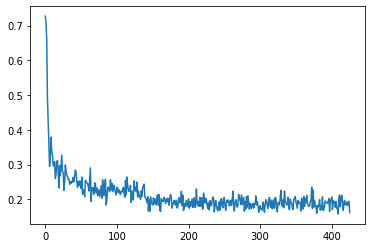

In [38]:
plt.plot(range(len(losses)), losses)

### Validating the net

In [39]:
x_numerical_train, x_categorical_train, y_train = train_ds.reverse_transform()

In [40]:
x_numerical_val, x_categorical_val, y_val = validation_ds.reverse_transform()

In [41]:
x_numerical_test, x_categorical_test, _ = test_ds.reverse_transform()

In [42]:
y_train_pred = model.predict(train_dl_for_prediction).numpy().squeeze()

In [43]:
y_val_pred = model.predict(validation_dl).numpy().squeeze()

In [44]:
#y_test_pred = model.predict(test_dl).numpy().squeeze()

#### Training

In [45]:
aucroc_train = roc_auc_score(y_train, y_train_pred)
print(f'Auc Roc in training: {aucroc_train}')

Auc Roc in training: 0.9293487262472389


In [46]:
accuracy_train = accuracy_score(y_train, [1 if pred >= .5 else 0 for pred in y_train_pred])
print(f'Accuracy in training: {accuracy_train}')

Accuracy in training: 0.9220380474244342


#### Validation

In [47]:
aucroc_val = roc_auc_score(y_val, y_val_pred)
print(f'Auc Roc in test: {aucroc_val}')

Auc Roc in test: 0.8619401828373031


In [48]:
accuracy_val = accuracy_score(y_val, [1 if pred >= .5 else 0 for pred in y_val_pred])
print(f'Accuracy in test: {accuracy_val}')

Accuracy in test: 0.908276167293649


#### Testing

In [49]:
#aucroc_test = roc_auc_score(y_test, y_test_pred)
#print(f'Auc Roc in test: {aucroc_test}')

In [50]:
#accuracy_test = accuracy_score(y_test, [1 if pred >= .5 else 0 for pred in y_test_pred])
#print(f'Accuracy in test: {accuracy_test}')